## 간단한 컨볼루션넷

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (28, 28, 1))
x = layers.Conv2D(filters = 32, kernel_size = 3 , activation = 'relu')(inputs)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3 , activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3 , activation = 'relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation = 'softmax')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 17s 4ms/step - loss: 0.1630 - accuracy: 0.9492
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0464 - accuracy: 0.9864
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0333 - accuracy: 0.9898
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0240 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0190 - accuracy: 0.9941


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트 정확도 : {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0303 - accuracy: 0.9900
테스트 정확도 : 0.990


# 개 vs 고양이 이미지 분류하기

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyeontaelee","key":"3dd96eee16e99d6dba90709b3153bd52"}'}

In [9]:
!cp kaggle.json ~/.kaggle/
!chmod 600 kaggle.json

In [10]:
!kaggle competitions download -c dogs-vs-cats
!unzip --qq dogs-vs-cats.zip
!unzip -qq train.zip

100% 811M/812M [00:24<00:00, 41.8MB/s]
100% 812M/812M [00:24<00:00, 34.3MB/s]


In [12]:
# 이미지 -> 훈련, 검증, 테스트 디렉터리로 복사하기
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ('cat', 'dog'):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

make_subset("train", start_index = 0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)


In [13]:
# 소규모 모델 만들기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (180, 180, 3)) # 가로세로 180의 RGB 이미지를 인풋으로 기대
x = layers.Rescaling(1./255)(inputs) # 입력을 [0, 1]로 스케일을 조정함
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [14]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [15]:
# 데이터 전처리 : image_dataset_from_directory() 이용
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [16]:
# dataset 맛보기
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size = (1000, 16))

# 넘파이 배열, 튜플, 딕셔너리 -> Dataset 생성 가능
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

# 1개의 샘플 반환
for i, element in enumerate(dataset):
	print(element.shape)
	if i>=2:
		break

# 1개의 배치 반환
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
	print(element.shape)
	if i>=2:
		break

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)


In [17]:
# Dataset이 반환하는 데이터, 레이블 크기 확인하기
for data_batch, labels_batch in train_dataset:
  print("데이터 배치 크기 : ", data_batch.shape)
  print("레이블 배치 크기 : ", labels_batch.shape)
  break


데이터 배치 크기 :  (32, 180, 180, 3)
레이블 배치 크기 :  (32,)


In [18]:
# 모델 훈련
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = "convnet_from_scratch.keras",
    save_best_only = True,
    monitor = "val_loss"
)]
history = model.fit(train_dataset,
                    epochs= 30,
                    validation_data = validation_dataset,
                    callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 19s 83ms/step - loss: 0.7173 - accuracy: 0.5080 - val_loss: 0.6906 - val_accuracy: 0.5620
Epoch 2/30
63/63 [==============================] - 6s 93ms/step - loss: 0.6900 - accuracy: 0.5355 - val_loss: 0.6808 - val_accuracy: 0.5570
Epoch 3/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6651 - accuracy: 0.6140 - val_loss: 0.6784 - val_accuracy: 0.5820
Epoch 4/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6270 - accuracy: 0.6570 - val_loss: 0.6180 - val_accuracy: 0.6570
Epoch 5/30
63/63 [==============================] - 6s 84ms/step - loss: 0.5814 - accuracy: 0.6985 - val_loss: 0.5900 - val_accuracy: 0.6870
Epoch 6/30
63/63 [==============================] - 6s 86ms/step - loss: 0.5540 - accuracy: 0.7290 - val_loss: 0.6989 - val_accuracy: 0.6740
Epoch 7/30
63/63 [==============================] - 6s 86ms/step - loss: 0.5229 - accuracy: 0.7435 - val_loss: 0.6622 - val_accuracy: 0.6730
Epoch 8/30
6

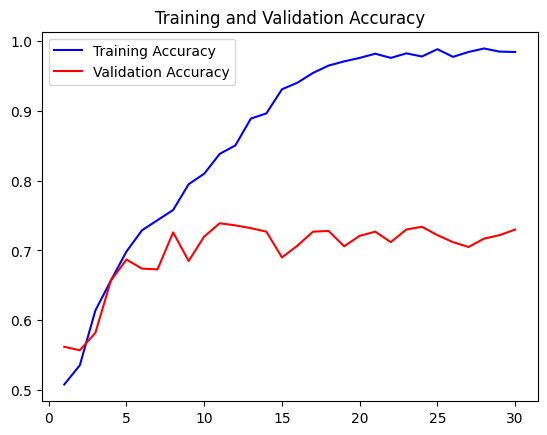

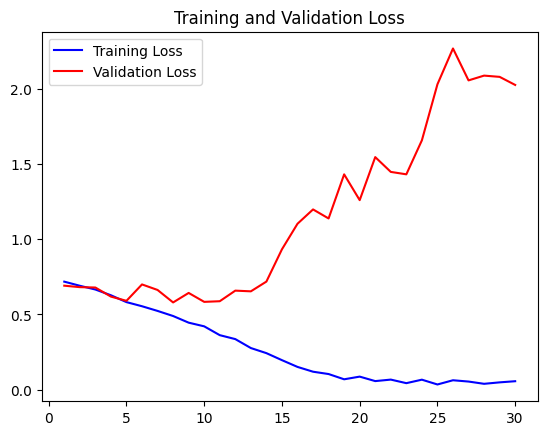

In [19]:
# 그래프 그리기
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy =history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label = "Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "b", label = "Training Loss")
plt.plot(epochs, val_loss, "r", label = "Validation Loss")
plt.title("Training and Validation Loss")

plt.legend()
plt.show()

In [20]:
# 테스트 세트에서 모델 평가하기
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도 : {test_acc:.3f}")

63/63 [==============================] - 5s 64ms/step - loss: 0.6380 - accuracy: 0.6940
테스트 정확도 : 0.694


## 데이터 증식 층

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

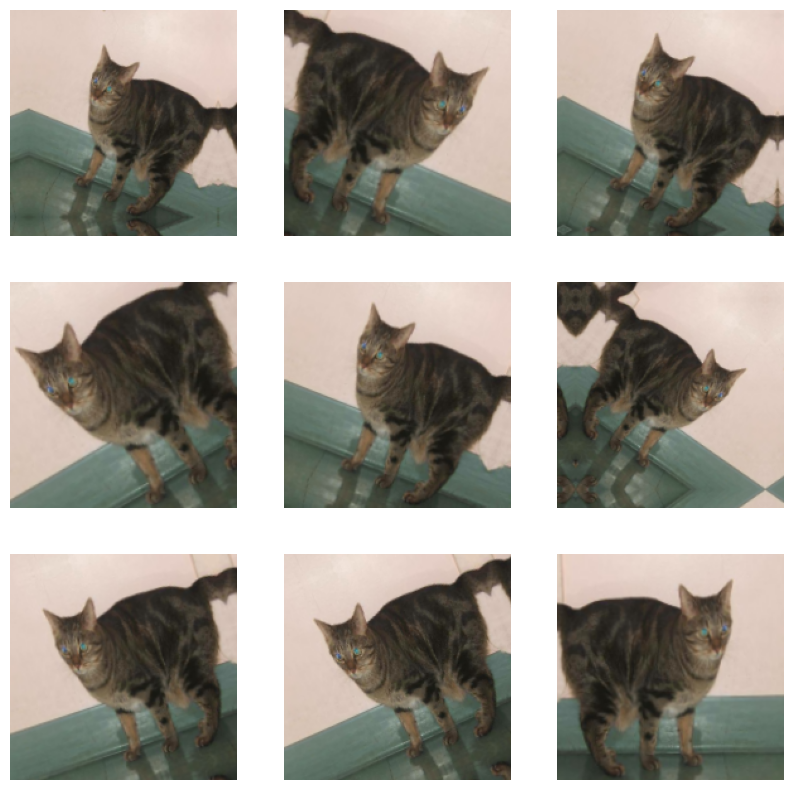

In [23]:
# 이미지 확인
plt.figure(figsize = (10, 10))
for images, _ in train_dataset.take(1): # N개의 배치만 샘플링
  for i in range(9):
    augmented_images = data_augmentation(images) # 이미지 증식 적용
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

In [25]:
inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_with_augmentation.keras",
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks= callbacks
)

Epoch 1/100
63/63 [==============================] - 7s 70ms/step - loss: 0.7319 - accuracy: 0.5025 - val_loss: 0.6925 - val_accuracy: 0.5030
Epoch 2/100
63/63 [==============================] - 5s 67ms/step - loss: 0.6935 - accuracy: 0.5050 - val_loss: 0.6915 - val_accuracy: 0.5020
Epoch 3/100
63/63 [==============================] - 6s 89ms/step - loss: 0.6936 - accuracy: 0.5140 - val_loss: 0.6877 - val_accuracy: 0.5850
Epoch 4/100
63/63 [==============================] - 5s 71ms/step - loss: 0.6830 - accuracy: 0.5565 - val_loss: 0.6674 - val_accuracy: 0.6210
Epoch 5/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6718 - accuracy: 0.6020 - val_loss: 0.6438 - val_accuracy: 0.6450
Epoch 6/100
63/63 [==============================] - 6s 79ms/step - loss: 0.6595 - accuracy: 0.6255 - val_loss: 0.6467 - val_accuracy: 0.6120
Epoch 7/100
63/63 [==============================] - 4s 67ms/step - loss: 0.6155 - accuracy: 0.6580 - val_loss: 0.6066 - val_accuracy: 0.6440
Epoch 

In [37]:
def visualize(history):
  accuracy = history.history['accuracy']
  val_accuracy =history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "b", label = "Training Accuracy")
  plt.plot(epochs, val_accuracy, "r", label = "Validation Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, "b", label = "Training Loss")
  plt.plot(epochs, val_loss, "r", label = "Validation Loss")
  plt.title("Training and Validation Loss")

  plt.legend()
  plt.show()

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras",
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도 :  {test_acc:.3f}")

63/63 [==============================] - 3s 42ms/step - loss: 0.4852 - accuracy: 0.8190
테스트 정확도 :  0.819


### 사전 훈련 모델로 특성 추출하기

In [28]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (180, 180, 3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [30]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [32]:
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images) # 전처리된 입력 기대
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
validation_features, validation_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


1/1 [==============================] - 0s 21ms/step


In [36]:
# 밀집 연결 분류기 정의 & 훈련
inputs = keras.Input(shape = (5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = 'feature_extraction.keras',
    save_best_only = True,
    monitor = 'val_loss'
)]

history = model.fit(train_features, train_labels, epochs = 20, validation_data = (validation_features, validation_labels), callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 17.4196 - accuracy: 0.9315 - val_loss: 8.6152 - val_accuracy: 0.9490
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.6942 - accuracy: 0.9725 - val_loss: 3.4860 - val_accuracy: 0.9740
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4463 - accuracy: 0.9905 - val_loss: 5.2772 - val_accuracy: 0.9660
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 2.0201 - accuracy: 0.9830 - val_loss: 8.8196 - val_accuracy: 0.9640
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.3392 - accuracy: 0.9940 - val_loss: 6.1217 - val_accuracy: 0.9700
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7737 - accuracy: 0.9930 - val_loss: 3.9297 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.2697 - accuracy: 0.9950 - val_loss: 3.8044 - val_accuracy: 0.9800
Epoch 8/20
63/63 [

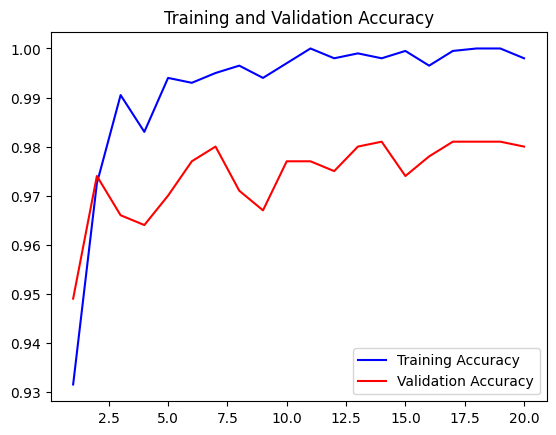

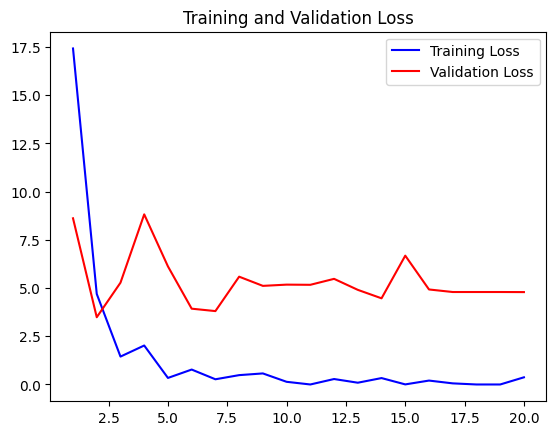

In [38]:
visualize(history)

### 데이터 증식 사용한 특성 추출

In [40]:
# 합성곱 기반 층 동결하기
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False
)
conv_base.trainable = False

In [45]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x) # 입력 값의 스케일 조정
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = 'feature_extraction_with_data_augmentation.keras',
    save_best_only = True,
    monitor = 'val_loss'
)]

history = model.fit(train_dataset,
                    epochs = 20,
                    validation_data = validation_dataset,
                    callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 14s 188ms/step - loss: 17.5279 - accuracy: 0.8930 - val_loss: 3.6759 - val_accuracy: 0.9760
Epoch 2/20
63/63 [==============================] - 10s 161ms/step - loss: 5.0736 - accuracy: 0.9520 - val_loss: 3.6356 - val_accuracy: 0.9760
Epoch 3/20
63/63 [==============================] - 10s 151ms/step - loss: 5.2314 - accuracy: 0.9560 - val_loss: 5.9440 - val_accuracy: 0.9640
Epoch 4/20
63/63 [==============================] - 12s 182ms/step - loss: 5.4816 - accuracy: 0.9575 - val_loss: 3.9451 - val_accuracy: 0.9790
Epoch 5/20
63/63 [==============================] - 10s 159ms/step - loss: 3.8934 - accuracy: 0.9730 - val_loss: 4.3690 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 13s 192ms/step - loss: 3.4768 - accuracy: 0.9660 - val_loss: 3.2438 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 11s 165ms/step - loss: 3.5162 - accuracy: 0.9700 - val_loss: 2.2641 - val_accuracy: 0.981

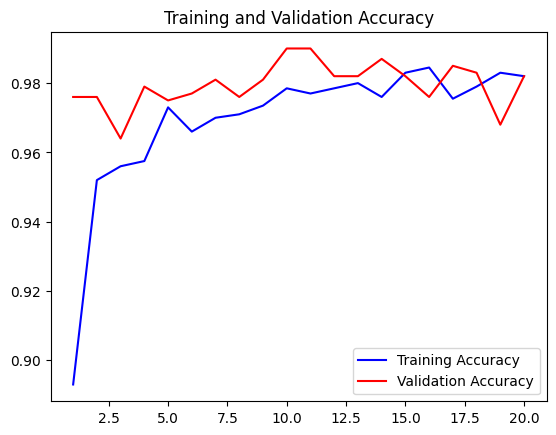

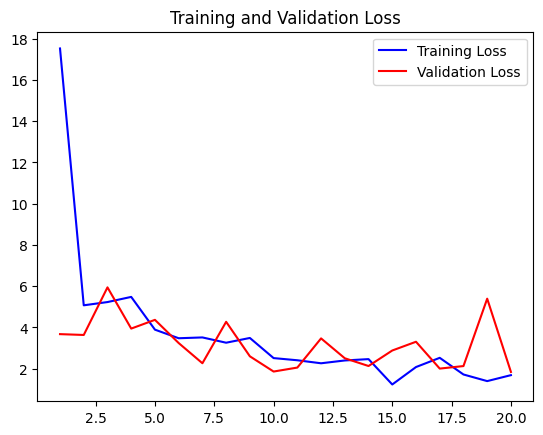

In [46]:
visualize(history)

In [48]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도 : {test_acc :.3f}")

63/63 [==============================] - 7s 93ms/step - loss: 3.1086 - accuracy: 0.9765
테스트 정확도 : 0.976


## 사전 훈련 모델 미세 조정하기

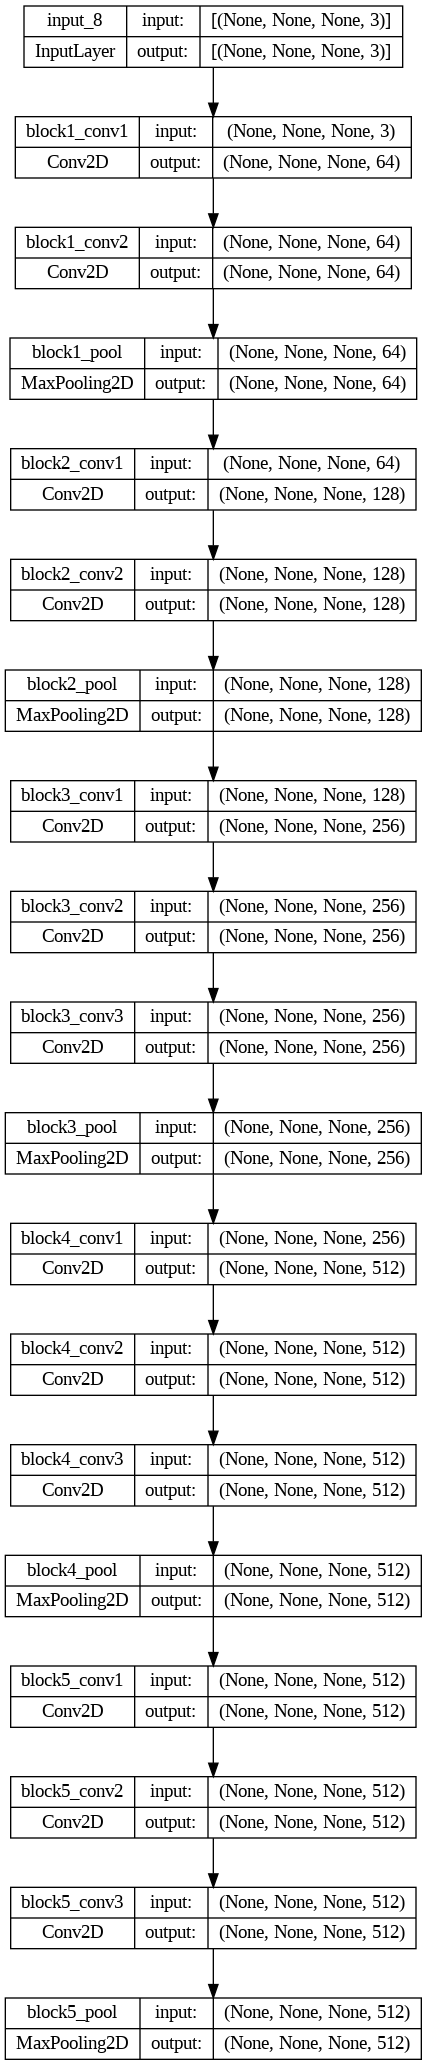

In [53]:
keras.utils.plot_model(conv_base, show_shapes = True)


In [54]:
# 마지막에서 4번째 층까지 동결
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [56]:
# 모델 미세 조정
model.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5),
              metrics =['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = 'fine_tuning.keras',
    save_best_only = True,
    monitor = 'val_loss'
)]

history = model.fit(train_dataset,
                    epochs = 20,
                    validation_data = validation_dataset,
                    callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 13s 172ms/step - loss: 0.8346 - accuracy: 0.9845 - val_loss: 1.5966 - val_accuracy: 0.9820
Epoch 2/20
63/63 [==============================] - 11s 170ms/step - loss: 0.5734 - accuracy: 0.9890 - val_loss: 1.4612 - val_accuracy: 0.9870
Epoch 3/20
63/63 [==============================] - 11s 167ms/step - loss: 0.3158 - accuracy: 0.9920 - val_loss: 1.8311 - val_accuracy: 0.9800
Epoch 4/20
63/63 [==============================] - 12s 185ms/step - loss: 0.4911 - accuracy: 0.9915 - val_loss: 1.8553 - val_accuracy: 0.9810
Epoch 5/20
63/63 [==============================] - 11s 170ms/step - loss: 0.3168 - accuracy: 0.9910 - val_loss: 2.1229 - val_accuracy: 0.9860
Epoch 6/20
63/63 [==============================] - 11s 163ms/step - loss: 0.4668 - accuracy: 0.9890 - val_loss: 1.9514 - val_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 13s 194ms/step - loss: 0.0994 - accuracy: 0.9955 - val_loss: 1.8102 - val_accuracy: 0.9800

In [57]:
model =  keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"테스트 정확도 : {test_acc:.3f}")

63/63 [==============================] - 6s 92ms/step - loss: 2.2636 - accuracy: 0.9780
테스트 정확도 : 0.978
